<a href="https://colab.research.google.com/github/miczkejedrzej/MNLP-project-1/blob/main/Modelisation_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Import of the training data

from google.colab import files
uploaded = files.upload()

# Import of moduls

!pip install wikidata --quiet
!pip install datasets --quiet
!pip install spacy --quiet
!python -m spacy download en_core_web_md

import matplotlib.pyplot as plt
import pandas as pd
from wikidata.client import Client
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, precision_score
import spacy
import seaborn as sns
from collections import Counter
import joblib
from google.colab import files
import tensorflow as tf


from tqdm.auto import tqdm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Loading the data
train_df = pd.read_json('train_df_complete.json', orient="records", lines=True)
dev_df = pd.read_json('dev_df_complete.json', orient="records", lines=True)

Saving dev_df_complete.json to dev_df_complete.json
Saving train_df_complete.json to train_df_complete.json
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 10.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you hav

# Spacey embeddings
 Firstly we will try to classify the descriptions based of their representation in the embeddings space of the spacey embeddings. We will use the knn classifier

In [ ]:
# Loading the pretrained model
nlp = spacy.load("en_core_web_md")

In [ ]:
import nltk
from nltk.stem import PorterStemmer
nltk.download('punkt_tab')
porter = PorterStemmer()
def transform_description(description):
  description = nltk.word_tokenize(description)
  description = [porter.stem(word) for word in description]
  return np.mean([nlp(word).vector for word in description],axis=0)/len(description)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
# Exctract the texte and the label : Training
train_texts = train_df['description'].to_list()
train_labels = train_df['label_int'].to_list()

# Exctract the texte and the label : Dev
dev_texts = dev_df['description'].to_list()
dev_labels = dev_df['label_int'].to_list()


# Vectorize the texts with en_core_web_m

train_vectors = np.array([nlp(text).vector for text in train_texts])
dev_vectors = np.array([nlp(text).vector for text in dev_texts])

accuracies = {}

# We test many values of k (number of neighbors in KNN)
for k in tqdm(range(1, 101)):
    knn = NearestNeighbors(n_neighbors=k, metric='cosine')
    knn.fit(train_vectors)

    predicted_labels = []

    for vec in dev_vectors:
        distances, indices = knn.kneighbors(vec.reshape(1, -1))

        # Get the k closest labels
        neighbor_labels = [train_labels[idx] for idx in indices[0]]

        # Choose the label (the most frequent one)
        label_counts = {}
        for label in neighbor_labels:
            label_counts[label] = label_counts.get(label, 0) + 1
        majority_label = max(label_counts.items(), key=lambda x: x[1])[0]

        predicted_labels.append(majority_label)

    # Compute accuracy
    accuracy = accuracy_score(dev_labels, predicted_labels)
    accuracies[k] = accuracy

# Plot Accuracy vs Number of Neighbors
plt.figure(figsize=(8, 5))
plt.plot(list(accuracies.keys()), list(accuracies.values()), marker='o', color='teal')
plt.title("Accuracy vs Number of Neighbors")
plt.xlabel("Number of Neighbors")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()
plt.savefig('Accuracy_vs_Neighbors')

KeyboardInterrupt: 

In [ ]:
# We get the best k : the one that gives the best accuracy
best_k = max(accuracies, key=accuracies.get)

# We train the final model, with best_k
knn = NearestNeighbors(n_neighbors=best_k, metric='cosine')
knn.fit(train_vectors)

# We predict the labels for each item of the dev set
final_predicted_labels = []
for vec in dev_vectors:
    distances, indices = knn.kneighbors(vec.reshape(1, -1))
    neighbor_labels = [train_labels[idx] for idx in indices[0]]
    majority_label = max(set(neighbor_labels), key=neighbor_labels.count)
    final_predicted_labels.append(majority_label)

dev_df['predicted_label_KNN'] = final_predicted_labels

In [ ]:
dev_df.head()

,item,name,description,type,label,subclass_depth,subclasses,instances_of,instances_of_up,date,...,category_fashion,category_comics and anime,category_music,category_films,category_biology,category_geography,category_combined,label_int,main_country_cat,predicted_label_KNN
0,http://www.wikidata.org/entity/Q15786,1. FC Nürnberg,"German sports club based in Nuremberg, Bavaria",entity,cultural representative,1,0,0,3,1900,...,0,0,0,0,0,0,0,1,1,0
1,http://www.wikidata.org/entity/Q268530,77 Records,UK record label,entity,cultural exclusive,1,0,0,1,1957,...,0,0,1,0,0,0,0,0,1,0
2,http://www.wikidata.org/entity/Q216153,A Bug's Life,1998 animated film directed by John Lasseter a...,entity,cultural representative,1,0,0,2,1998,...,0,1,0,0,0,0,0,1,1,1
3,http://www.wikidata.org/entity/Q593,A Gang Story,2011 film by Olivier Marchal,entity,cultural exclusive,1,0,0,1,2011,...,0,0,0,1,0,0,0,0,1,1
4,http://www.wikidata.org/entity/Q192185,Aaron Copland,"American composer, composition teacher, writer...",entity,cultural representative,1,0,0,1,1900,...,0,0,0,0,0,0,1,1,1,1


In [ ]:
dev_df['predicted_label_KNN'].value_counts()

In [ ]:
# Creation of the confusion matrix
y_true = dev_df['label_int']
y_pred = dev_df['predicted_label_KNN']
cm = confusion_matrix(y_true, y_pred)

# Plot
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

plt.title('Matrix Confusion : KNN estimation')
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')
plt.show()

In [ ]:
recall = recall_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred,average='macro')

print("Recall :", recall)
print("Precision :", precision)
print("F1-score :", f1)

# Fastext embeddings, knn and nn based classifiers

 - Here we explore the fasttext embeddings, because hypothetically they could give a better representation in case of the proper names, as they do not return an "unknown" vector in case the word is not in the embeddings base, but a average of the ngrams of the word
 - additionaly, in case, of unknown words, we will count the number of them in description and add it as an additional dimension to the neural network input, because this may hypothetically be an informative feature with regards to our classification task
 - Lastly we have gotten rid of the stop words of the descriptions as they would not bring an informative value

In [3]:
%pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 2.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp311-cp311-linux_x86_64.whl size=4313501 sha256=35fd61addfe1a2f729a5c1dea9af037eeeb427d06b28285ea5bdc6ce0caceeb1
  Stored in directory: /root/.cache/pip/wheels/65/4f/35/5057db0249224e9ab55a513fa6b79451473ceb7713017823c3
Successfully built fasttext


In [4]:
 import fasttext.util
 fasttext.util.download_model('en', if_exists='ignore')  # English
 ft = fasttext.load_model('cc.en.300.bin')

In [5]:
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt_tab')
porter = PorterStemmer()
stop_words = set(stopwords.words('english'))
from sklearn.preprocessing import normalize


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [6]:
'''transforming the descriptions to the embeddings space , adding the oov information'''
def transform_description(description):
  oov_words = 0
  description = nltk.word_tokenize(description)
  description = [word for word in description if word not in stop_words]
  description = [word.lower() for word in description]
  for word in description:
    if word not in ft.words:
      oov_words += 1
  description = " ".join(description)
  description_vector = ft.get_sentence_vector(description)
  description_vector = normalize(description_vector.reshape(1, -1), norm='l2')[0]
  description_vector = np.append(description_vector, oov_words)
  return description_vector

  0%|          | 0/9 [00:00<?, ?it/s]

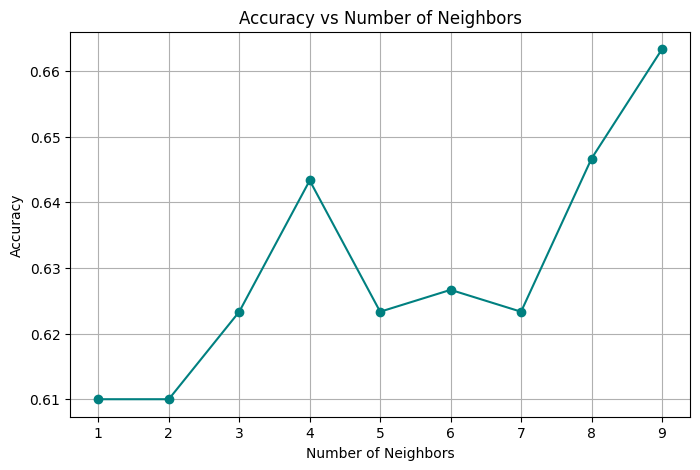

<Figure size 640x480 with 0 Axes>

In [7]:
train_texts = train_df['description'].to_list()
train_labels = train_df['label_int'].to_list()

# Exctract the text and the label : Dev
dev_texts = dev_df['description'].to_list()
dev_labels = dev_df['label_int'].to_list()

# Vectorize the texts with fasttext
train_vectors = np.array([transform_description(text) for text in train_texts])
dev_vectors = np.array([transform_description(text) for text in dev_texts])

accuracies = {}

# We test many values of k (number of neighbors in KNN)
for k in tqdm(range(1, 10)):
    knn = NearestNeighbors(n_neighbors=k, metric='cosine')
    knn.fit(train_vectors)

    predicted_labels = []

    for vec in dev_vectors:
        distances, indices = knn.kneighbors(vec.reshape(1, -1))

        # Get the k closest labels
        neighbor_labels = [train_labels[idx] for idx in indices[0]]

        # Choose the label (the most frequent one)
        label_counts = {}
        for label in neighbor_labels:
            label_counts[label] = label_counts.get(label, 0) + 1
        majority_label = max(label_counts.items(), key=lambda x: x[1])[0]

        predicted_labels.append(majority_label)

    # Compute accuracy
    accuracy = accuracy_score(dev_labels, predicted_labels)
    accuracies[k] = accuracy

# Plot Accuracy vs Number of Neighbors
plt.figure(figsize=(8, 5))
plt.plot(list(accuracies.keys()), list(accuracies.values()), marker='o', color='teal')
plt.title("Accuracy vs Number of Neighbors")
plt.xlabel("Number of Neighbors")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()
plt.savefig('Accuracy_vs_Neighbors')

In [8]:
# We get the best k : the one that gives the best accuracy
best_k = max(accuracies, key=accuracies.get)

# We train the final model, with best_k
knn = NearestNeighbors(n_neighbors=best_k, metric='cosine')
knn.fit(train_vectors)

# We predict the labels for each item of the dev set
final_predicted_labels = []
for vec in dev_vectors:
    distances, indices = knn.kneighbors(vec.reshape(1, -1))
    neighbor_labels = [train_labels[idx] for idx in indices[0]]
    majority_label = max(set(neighbor_labels), key=neighbor_labels.count)
    final_predicted_labels.append(majority_label)

dev_df['predicted_label_KNN'] = final_predicted_labels

In [9]:
dev_df['predicted_label_KNN'].value_counts()

,count
predicted_label_KNN,
0,118
2,113
1,69


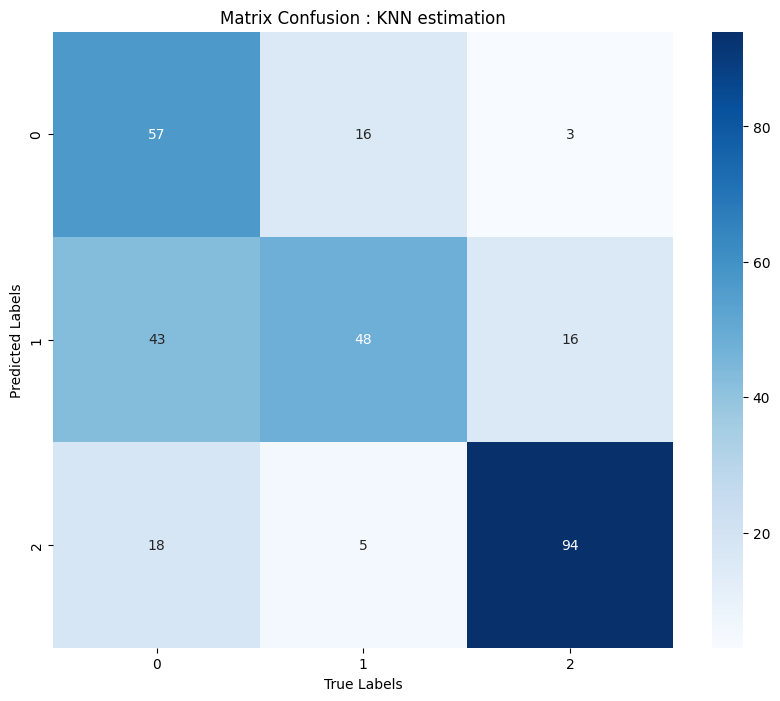

In [10]:
# Creation of the confusion matrix
y_true = dev_df['label_int']
y_pred = dev_df['predicted_label_KNN']
cm = confusion_matrix(y_true, y_pred)

# Plot
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

plt.title('Matrix Confusion : KNN estimation')
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')
plt.show()

In [11]:
recall = recall_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred,average='macro')

print("Recall :", recall)
print("Precision :", precision)
print("F1-score :", f1)

Recall : 0.6673389780866416
Precision : 0.6701871428167722
F1-score : 0.6501582385939177


### Neural network model

In [12]:
!pip install tensorflow --quiet

In [13]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LeakyReLU
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder,MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras.utils import to_categorical
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.model_selection import StratifiedKFold

### Cross validation , hyperparameter tuning
the 5 fold cross validation is run for our nn model in order to determine the proper number of epochs for the nn

In [14]:
early_stop = callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)




kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
epochs_per_fold = []

for train_index, val_index in kfold.split(train_vectors,train_labels):

    X_train_fold, X_val_fold = train_vectors[train_index], train_vectors[val_index]
    y_train_fold, y_val_fold = np.array(train_labels)[train_index], np.array(train_labels)[val_index]

    model_classification = models.Sequential()
    model_logits = models.Sequential()


    input_layer = layers.Input(shape=(301,), name='input_layer')
    model_classification.add(input_layer)
    model_logits.add(input_layer)

    for units in [1024, 1024, 512, 512, 256, 256, 128, 128, 64, 64, 32, 32]:

        dense_layer = layers.Dense(units, activation='relu')
        relu_layer = LeakyReLU(alpha=0.1)
        batch_norm_layer = layers.BatchNormalization()
        dropout_layer = layers.Dropout(0.3 if units > 128 else 0.2)

        model_classification.add(dense_layer)
        model_classification.add(relu_layer)
        model_classification.add(batch_norm_layer)
        model_classification.add(dropout_layer)




    logits_layer = layers.Dense(3, name='logits_layer')
    model_classification.add(logits_layer)


    softmax_layer = layers.Softmax(name='softmax_layer')
    model_classification.add(softmax_layer)


    model_classification.compile(optimizer=Adam(learning_rate=1e-3),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])



    train_labels_nn = to_categorical(train_labels, num_classes=3)
    dev_labels_nn = to_categorical(dev_labels, num_classes=3)




    history = model_classification.fit(
        X_train_fold, y_train_fold,
        validation_data=(X_val_fold, y_val_fold),
        epochs=200,
        batch_size=64,
        callbacks=[early_stop, reduce_lr]
    )

    epochs_per_fold.append(len(history.history['loss']))


print(f"Average number of epochs per fold is : {np.mean(epochs_per_fold)}")




/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 31s 120ms/step - accuracy: 0.3488 - loss: 1.5096 - val_accuracy: 0.3038 - val_loss: 1.0972 - learning_rate: 0.0010
Epoch 2/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step - accuracy: 0.3966 - loss: 1.1858 - val_accuracy: 0.5068 - val_loss: 1.0414 - learning_rate: 0.0010
Epoch 3/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step - accuracy: 0.4793 - loss: 1.0442 - val_accuracy: 0.5500 - val_loss: 0.9299 - learning_rate: 0.0010
Epoch 4/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - accuracy: 0.5616 - loss: 0.9189 - val_accuracy: 0.5795 - val_loss: 0.8789 - learning_rate: 0.0010
Epoch 5/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 107ms/step - accuracy: 0.5734 - loss: 0.8841 - val_accuracy: 0.6475 - val_loss: 0.7702 - learning_rate: 0.0010
Epoch 6/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - accuracy: 0.5917 - loss: 0.8724 - val_accuracy: 0.6475 - val_loss: 0.7592 - learning_rate: 0.0010
Epoch 7/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 110ms/step - accuracy: 0.6160 - loss: 

### Retraining on the  entire training set

Now, knowing the number of epochs we are retraining the model on the whole training set

In [20]:

import math

model_classification = models.Sequential()
model_logits = models.Sequential()

# Input
input_layer = layers.Input(shape=(301,), name='input_layer')
model_classification.add(input_layer)
model_logits.add(input_layer)

for units in [1024, 1024, 512, 512, 256, 256, 128, 128, 64, 64, 32, 32]:

    dense_layer = layers.Dense(units, activation='relu')
    relu_layer = LeakyReLU(alpha=0.1)
    batch_norm_layer = layers.BatchNormalization()
    dropout_layer = layers.Dropout(0.3 if units > 128 else 0.2)

    model_classification.add(dense_layer)
    model_classification.add(relu_layer)
    model_classification.add(batch_norm_layer)
    model_classification.add(dropout_layer)


    model_logits.add(dense_layer)
    model_logits.add(relu_layer)
    model_logits.add(batch_norm_layer)
    model_logits.add(dropout_layer)

logits_layer = layers.Dense(3, name='logits_layer')
model_classification.add(logits_layer)
model_logits.add(logits_layer)

softmax_layer = layers.Softmax(name='softmax_layer')
model_classification.add(softmax_layer)


model_classification.compile(optimizer=Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


train_labels_nn = to_categorical(train_labels, num_classes=3)
dev_labels_nn = to_categorical(dev_labels, num_classes=3)




history = model_classification.fit(
    train_vectors, train_labels_nn,
    epochs=math.floor(np.mean(epochs_per_fold))-1,
    batch_size=64,
)


logits_dev = model_logits.predict(dev_vectors)
logits_train = model_logits.predict(train_vectors)
np.save("dev_logits_description.npy", logits_dev)
np.save("train_logits_description.npy", logits_train)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 28s 70ms/step - accuracy: 0.3627 - loss: 1.3989
Epoch 2/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.4244 - loss: 1.1273
Epoch 3/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - accuracy: 0.5216 - loss: 0.9866
Epoch 4/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.5727 - loss: 0.8958
Epoch 5/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.6067 - loss: 0.8329
Epoch 6/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.6348 - loss: 0.7796
Epoch 7/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.6500 - loss: 0.7530
Epoch 8/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - accuracy: 0.6626 - loss: 0.7206
Epoch 9/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - accuracy: 0.6842 - loss: 0.6947
Epoch 10/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.6858 - loss: 0.6694
Epoch 11/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.7092 - loss: 0.6558
Epoch 12/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - ac

### Evaluation
Evaluation on the train and dev set now

In [22]:
y_dev_pred = model_classification.predict(dev_vectors)
y_train_pred = model_classification.predict(train_vectors)
y_train_pred_classes = np.argmax(y_train_pred, axis=1)
y_dev_pred_classes = np.argmax(y_dev_pred, axis=1)
y_dev_true_classes = np.argmax(dev_labels_nn, axis=1)
y_train_true_classes = np.argmax(train_labels_nn, axis=1)

# Accuracy

dev_accuracy = accuracy_score(y_dev_true_classes, y_dev_pred_classes)
train_accuracy = accuracy_score(y_train_true_classes, y_train_pred_classes)

print(f"Train accuracy : {train_accuracy * 100:.2f}%")
print(f"Dev accuracy   : {dev_accuracy * 100:.2f}%")


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Train accuracy : 88.82%
Dev accuracy   : 71.00%


# NN exportation


In [19]:
model_logits.save("model_logits.keras")

#Knn Exportation

In [ ]:
knn

NearestNeighbors(metric='cosine', n_neighbors=24)

In [ ]:
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'cosine',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 24,
 'p': 2,
 'radius': 1.0}

In [ ]:
# Save
joblib.dump(knn, 'model_KNN.joblib')

# Download
files.download('model_KNN.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>